In [1]:
%%time
import bayes3d as b

CPU times: user 4.09 s, sys: 1.95 s, total: 6.04 s
Wall time: 3.4 s


In [2]:
import numpy as np
import os
import jax
import jax.numpy as jnp
import trimesh
import time
import pickle
import bayes3d.transforms_3d as t3d
import bayes3d as b
import bayes3d as j
import bayes3d.meshcat
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import namedtuple


In [3]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


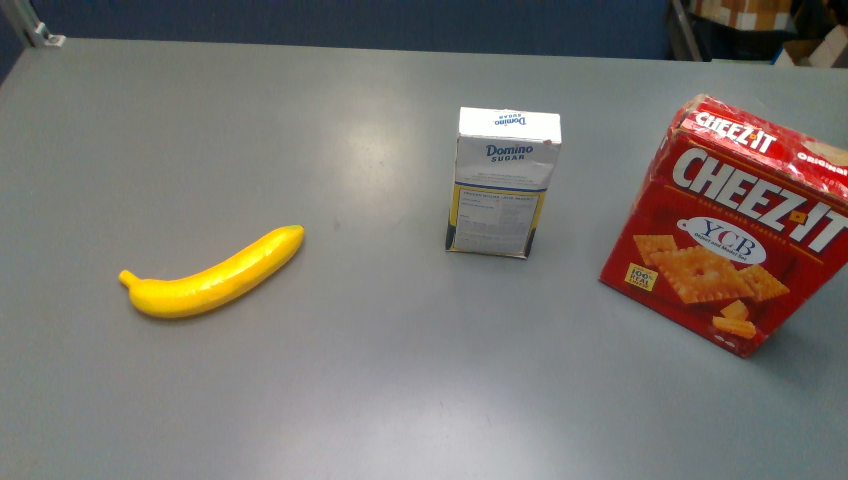

In [5]:
test_pkl_file = os.path.join(b.utils.get_assets_dir(),"sample_imgs/cracker_sugar_banana_real.pkl.rgbds")
with  open(test_pkl_file,'rb') as f:
    rgbds = pickle.load(f)
image = rgbds[0]
b.get_rgb_image(image.rgb)

In [6]:
import cv2

In [8]:
original_pc_image = b.t3d.unproject_depth_jit(image.depth, image.intrinsics)
intrinsics = b.camera.scale_camera_parameters(image.intrinsics, 0.25)

w,h = intrinsics.width, intrinsics.height
observed_point_cloud_image = cv2.resize(np.asarray(original_pc_image, dtype=original_pc_image.dtype), (w,h),interpolation=0).astype(original_pc_image.dtype)

In [9]:
plane_pose, plane_dims = b.utils.find_plane_and_dims(observed_point_cloud_image.reshape(-1,3))
if plane_pose[:3,2][2] > 0:
    plane_pose = plane_pose @ t3d.transform_from_axis_angle(jnp.array([1.0, 0.0, 0.0]), jnp.pi)
b.clear()
b.show_cloud("1", observed_point_cloud_image.reshape(-1,3))
b.show_pose("2", plane_pose)

In [10]:
renderer = b.Renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    renderer.add_mesh_from_file(mesh_path,scaling_factor=1.0/1000.0)
SCALING_FACTOR = 3

Increasing frame buffer size to (width, height, depth) = (224, 128, 512)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


In [80]:
VARIANCE_GRID = jnp.array([0.0005, 0.0001, 0.00001]).reshape(-1,1)
OUTLIER_GRID = jnp.linspace(0.01, 0.7, 4)
OUTLIER_VOLUME = 1.0**3

grid_params = [
    (0.2, jnp.pi, (11,11,5)), (0.1, jnp.pi/5, (11,11,5)), (0.1, jnp.pi/5, (11,11,5)),
    (0.0, jnp.pi, (1,1,7*7)), (0.05, jnp.pi/5/5, (11,11,5))
]
contact_param_gridding_schedule = [
    b.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]

contact_poses_jit = jax.jit(jax.vmap(b.scene_graph.relative_pose_from_edge, in_axes=(0,None, None)))


In [93]:
contact_plane = plane_pose
VARIANCES_PER_OBJECT = jnp.array([0.00001])
object_poses, object_ids = jnp.zeros((0,1,4,4)), []

In [101]:
all_hypotheses = []

for obj_id in tqdm(range(21)):
    contact_param = jnp.zeros(3)
    p = None
    for c2f_iter in range(len(contact_param_gridding_schedule)):
        contact_param_grid = contact_param_gridding_schedule[c2f_iter] + contact_param

        potential_new_object_poses = contact_plane @ contact_poses_jit(
            contact_param_grid,
            3,
            renderer.model_box_dims[obj_id],
        )
        POTENTIAL_R = jnp.hstack([jnp.tile(VARIANCES_PER_OBJECT[None,:], (VARIANCE_GRID.shape[0], 1)),VARIANCE_GRID])

        potential_poses = jnp.concatenate(
            [
                jnp.tile(object_poses, (1,potential_new_object_poses.shape[0],1,1)),
                potential_new_object_poses[None,...]
            ]
        )

        reconstruction = renderer.render_multiobject_parallel(
            potential_poses, object_ids + [obj_id]
        )
        p = b.threedp3_likelihood_multi_r_full_hierarchical_bayes_jit(
            observed_point_cloud_image, reconstruction[:,:,:,:3], reconstruction[:,:,:, -1],
            POTENTIAL_R, OUTLIER_GRID, OUTLIER_VOLUME,
            3
        )       
        
        ii,jj,kk = jnp.unravel_index(p.argmax(), p.shape)
        contact_param = contact_param_grid[ii]
    
    best_r, best_outlier_prob = (POTENTIAL_R[jj], OUTLIER_GRID[kk])

    all_hypotheses.append(
        (p[ii,jj,kk], reconstruction[ii], best_r, best_outlier_prob, potential_poses[:,ii], obj_id)
    )

scores = jnp.array([i[0] for i in all_hypotheses])
print(b.utils.normalize_log_scores(scores))
print(jnp.argsort(-scores))
best_hypothesis = all_hypotheses[jnp.argmax(scores)]
score, reconstruction, best_r, best_outlier_prob, best_poses, obj_id = best_hypothesis
print("Best")
print(best_r, best_outlier_prob, obj_id)

VARIANCES_PER_OBJECT = best_r
object_poses = best_poses[:,None,...]
object_ids = object_ids + [obj_id]
print((
    object_poses,
    object_ids
))

100%|███████████████████████████████| 21/21 [00:12<00:00,  1.65it/s]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[12 16 19 18  7  9  6  5 13 14 17  1 15 11  0 20  2  8  4 10  3]
Best
[1.e-05 1.e-05 1.e-05 1.e-05 1.e-04] 0.7 12
(Array([[[[ 0.58548784, -0.8108279 ,  0.01065813,  0.28921956],
         [-0.66675353, -0.48885137, -0.56298846, -0.02466287],
         [ 0.461662  ,  0.32250044, -0.82666004,  0.5567809 ],
         [ 0.        ,  0.        ,  0.        ,  1.        ]]],


       [[[ 0.01796532, -1.0000622 ,  0.01065812,  0.07872898],
         [-0.8265859 , -0.02084804, -0.5629884 , -0.07271746],
         [ 0.5632077 ,  0.00131116, -0.82666004,  0.6094747 ],
         [ 0.        ,  0.        ,  0.        ,  1.        ]]],


       [[[ 0.9988835 , -0.05008598,  0.0106582 , -0.31130734],
         [-0.03541306, -0.82601964, -0.56298846,  0.13353343],
         [ 0.03699241,  0.5619451 , -0.82666004,  0.5372313 ],
         [ 0.        ,  0.        ,  0.        ,  1.        ]]],


       [[[-0.96948844, -0.24578029,  0.01065818, -0.

[1.e-05 1.e-05 1.e-05 1.e-05 1.e-04]


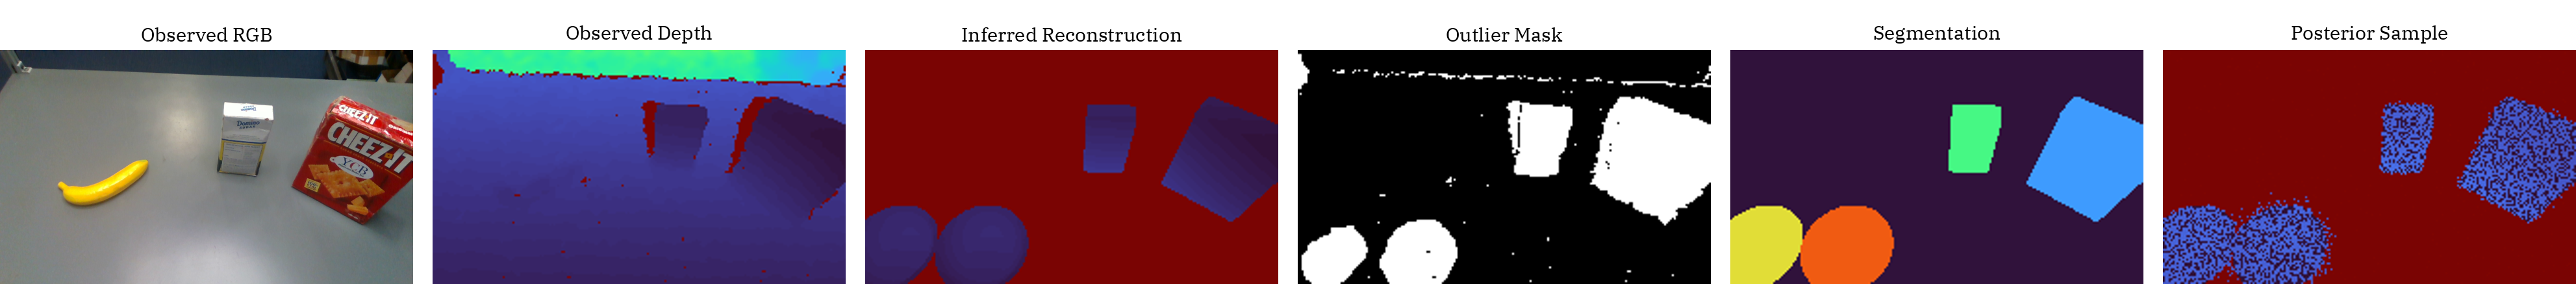

In [102]:
rgb = image.rgb
reconstruction = renderer.render_multiobject(
    object_poses, object_ids
)
inliers = (
    (jnp.log(1.0 - best_outlier_prob)  + j.threedp3_likelihood_multi_r_per_pixel_jit(
        observed_point_cloud_image, reconstruction[:,:,:3], reconstruction[:,:, -1], best_r, 0.0, 1.0,3
    ))
        >
    jnp.log(best_outlier_prob / OUTLIER_VOLUME)
)

rendered_seg = reconstruction[:,:,3]
j.get_depth_image(reconstruction[:,:,2])
r_array = VARIANCES_PER_OBJECT

print(r_array, )
r = r_array[jnp.abs(rendered_seg[..., None] - jnp.arange(len(r_array))).argmin(-1)]
key = jax.random.PRNGKey(12)
noisy_point_cloud_image = jax.random.multivariate_normal(
    key, reconstruction[:,:,:3], (jnp.eye(3)[None, None, :, :] * r[:,:,None,None]), shape=r.shape
)
img = j.render_point_cloud(noisy_point_cloud_image.reshape(-1,3), intrinsics)
j.scale_image(j.get_depth_image(img[:,:,2]),10)

viz2 = j.multi_panel(
    [
        j.scale_image(j.get_rgb_image(rgb),SCALING_FACTOR/4),
        j.scale_image(j.get_depth_image(observed_point_cloud_image[:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(reconstruction[:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(1.0 *inliers,cmap=plt.cm.gray, min=0.0, max=1.0), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(reconstruction[:,:,3], max=5.0), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(img[:,:,2]), SCALING_FACTOR),
    ],
    labels=[
        "Observed RGB",
        "Observed Depth",
        "Inferred Reconstruction",
        "Outlier Mask",
        "Segmentation",
        "Posterior Sample",
    ],
    middle_width=30
)

viz2

In [100]:
j.clear()
b.show_cloud("1", observed_point_cloud_image.reshape(-1,3))
for i in range(len(object_poses)):
    j.show_trimesh(f"obj_{i}", renderer.meshes[object_ids[i]])
    j.set_pose(f"obj_{i}", object_poses[i])